# Linear problem
### Numerical solution

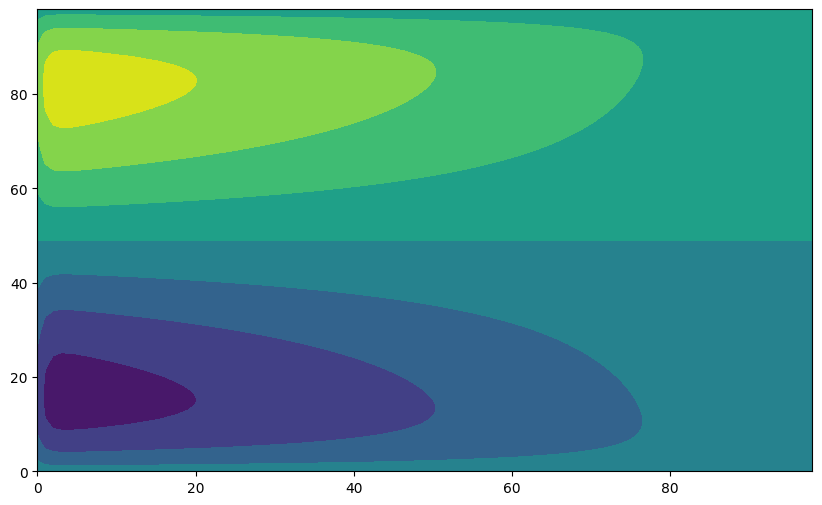

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve
from matplotlib.animation import FuncAnimation
#from scipy.sparse.linalg import eigs

def laplacian2D(N):
    diag=np.ones([N*N])
    mat=sp.spdiags([diag,-2*diag,diag],[-1,0,1],N,N)
    I=sp.eye(N)
    return sp.kron(I,mat,format='csr')+sp.kron(mat,I)


def ddx2D(N):
    diag=np.ones([N*N])
    mat=sp.spdiags([-diag,0*diag,diag],[-1,0,1],N,N)
    I=sp.eye(N)
    return sp.kron(I,mat,format='csr')

def ddy2D(N):
    diag=np.ones([N*N])
    mat=sp.spdiags([-diag,0*diag,diag],[-1,0,1],N,N)
    I=sp.eye(N)
    return sp.kron(mat,I)


N = 100
dx = 1/N
x = np.linspace(dx,1-dx,N-1)
y = np.linspace(dx,1-dx,N-1)
x, y = np.meshgrid(x,y)
pi = np.pi

  
lap = laplacian2D(N-1)/dx**2
ddx = ddx2D(N-1)/(2*dx)
ddy = ddy2D(N-1)/(2*dx)
#lap = lap.toarray()

r = 0.01
beta = 1
nu = 0.001

A = r * lap + beta * ddx
B = - nu * lap.dot(lap) - beta * ddx
f = 0.005*np.cos(pi*y)
f_long = np.reshape(f,(N-1)**2)

niter=8
fig, ax = plt.subplots(1, figsize = (10, 6))

psi_long = spsolve(A,f_long)
psi = np.reshape(psi_long,(N-1,N-1)) 
plt.contourf(psi)


# for i in range(niter):
#     q_long = lap.dot(psi_long)
#     q_long_x = ddx.dot(q_long)
#     q_long_y = ddy.dot(q_long)
#     psi_long_x = ddx.dot(psi_long)
#     psi_long_y = ddy.dot(psi_long)
#     rhs_long = f_long - (psi_long_x*q_long_y - psi_long_y*q_long_x)
    
    
#     #psi_long = spsolve(A,rhs_long)
#     psi_long = spsolve(B,rhs_long)
    
#     psi = np.reshape(psi_long,(N-1,N-1)) 
#     ax[i].contourf(x,y,psi)



# psi = np.sin(5*pi*x)*np.sin(3*pi*y)


# psi_long = np.reshape(psi,((N-1)**2,1))

# #q_long = lap.dot(psi_long)
# q_long = ddy.dot(psi_long)

# q = np.reshape(q_long,(N-1,N-1))

# fig, ax = plt.subplots(2)

# ax[0].contourf(x,y,psi)
# ax[1].contourf(x,y,q)

#print(np.max(q)/pi)

#print(lap.toarray())
#vals, vecs = eigs(lap,k=(N-1)**2)
#print(vals)
#print(vecs)

### Analytical solution
##### Stommel model

Given the model

$$
\epsilon\nabla^2\psi(x, y) + \partial_x\psi(x, y) = \text{curl}_z(\bm\tau_T), 
$$

where we assume

\begin{align*}
   \psi(x, y) &= \sum_{n = 1}^{\infty}f_n(x)\sin(n\pi y), \text{ and} \\
   (\ g(y) = \ ) \quad\text{curl}_z(\bm\tau_T) &= \sum_{n=1}^\infty A_n\sin(n\pi y).
\end{align*}

Each $f_n(x)$ satisfies

$$
\epsilon f_n''(x) + f_n'(x) - \epsilon n^2\pi^2f_n(x) = A_n, 
$$

and 

$$
A_n = \int_{-1}^1g(y)\sin(n\pi y)dy.
$$

In [3]:
from scipy import integrate
from tqdm import tqdm

def f_n(x, epsilon, g, n):
    '''
        Compute n-th term of the Fourier series
    '''
    # N-th coefficient of the Fourier series of the curl
    A_n, _ = integrate.quad(lambda y: g(y) * np.sin(n * np.pi * y), -1, 1)

    # Roots of the characteristic equation
    root1 = (-1 + np.sqrt(1 + 4 * (n**2) * (np.pi**2) * (epsilon**2)))/(2 * epsilon)
    root2 = (-1 - np.sqrt(1 + 4 * (n**2) * (np.pi**2) * (epsilon**2)))/(2 * epsilon)

    # Particular solution of the ode
    par_soln = -A_n/(epsilon * np.pi**2 * n**2)

    # Boundary conditions
    M = np.array([[1, 1], 
                  [np.exp(root1), np.exp(root2)]])
    M_A = np.full((2, 1), -par_soln)
    C = np.linalg.inv(M) @ M_A

    F_n = C[0] * np.exp(root1 * x) + C[1] * np.exp(root2 * x) + par_soln
    
    return F_n


def psi(x, y, epsilon, g, N):
    '''
        Streamfunction
    '''
    Psi = np.zeros_like(x)

    # Compute terms of the Fourier series
    for n in range(1, N + 1):
        Psi = Psi + f_n(x = x, epsilon = epsilon, g = g, n = n) * np.sin(n * np.pi * y)
    
    return Psi


def psi_approx(x, y, epsilon, A):
    '''
        Approximate streamfunction given in the book
    '''
    return (1 - x - np.exp(-x/epsilon)) * np.pi * np.sin(np.pi * y)

##### Plotting the analytical solutions of the Stommel model

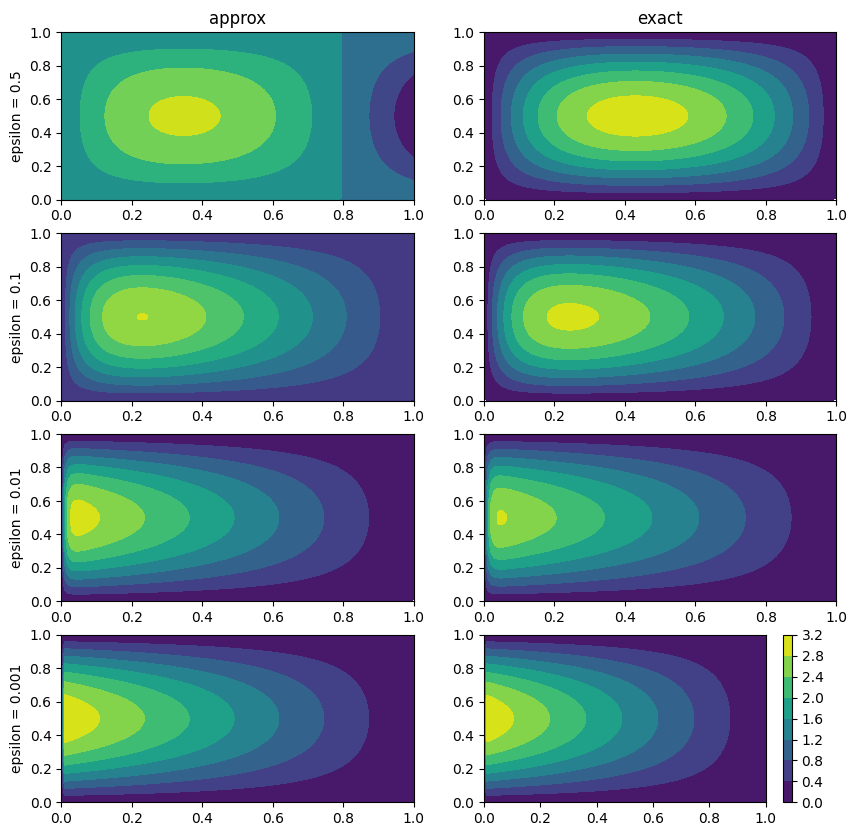

In [4]:
epsilons = [0.5, 0.1, 0.01, 0.001]

num_grid = 100
x = np.linspace(0,1,num_grid)
y = np.linspace(0,1,num_grid)
x, y = np.meshgrid(x,y)

def g(y):
    return -np.pi * np.sin(np.pi * y)

fig, ax = plt.subplots(4, 2, figsize = (10, 10))

for i in range(4):
    epsilon = epsilons[i]

    Psi_approx = psi_approx(x, y, epsilon, A)
    Psi = psi(x = x, y = y, epsilon = epsilon, g = g, N = 30)

    ax[i, 0].contourf(x, y, Psi_approx)
    c_ = ax[i, 1].contourf(x, y, Psi)
    
    ax[i, 0].set(ylabel = f'epsilon = {epsilon}')


ax[0, 0].set(title = 'approx')
ax[0, 1].set(title = 'exact')


cbar = fig.colorbar(c_)
plt.show()

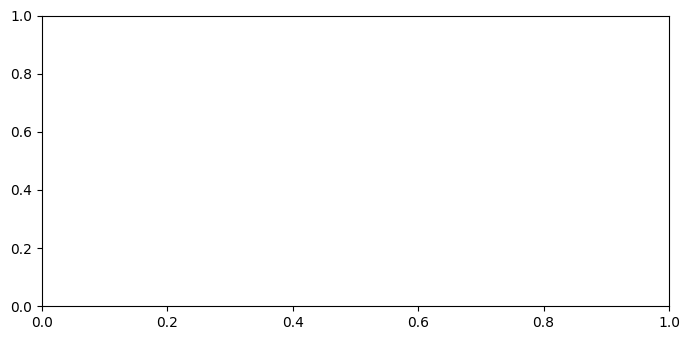

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
data = np.random.randn(800).reshape(10, 10, 8)
fig, ax = plt.subplots()
def animate(i):
    ax.clear()
    ax.contourf(data[:, :, i])
ani = animation.FuncAnimation(fig, animate, 5, interval=50, blit=False)
plt.show()

 43%|████▎     | 427/1000 [01:51<02:17,  4.16it/s]/tmp/ipykernel_11019/3696444214.py:39: RuntimeWarning: overflow encountered in multiply
  rhs_long = f_long - (psi_long_x*q_long_y - psi_long_y*q_long_x) + 1/dt * lap.dot(psi_long)
/tmp/ipykernel_11019/3696444214.py:39: RuntimeWarning: invalid value encountered in subtract
  rhs_long = f_long - (psi_long_x*q_long_y - psi_long_y*q_long_x) + 1/dt * lap.dot(psi_long)
100%|██████████| 1000/1000 [04:22<00:00,  3.82it/s]


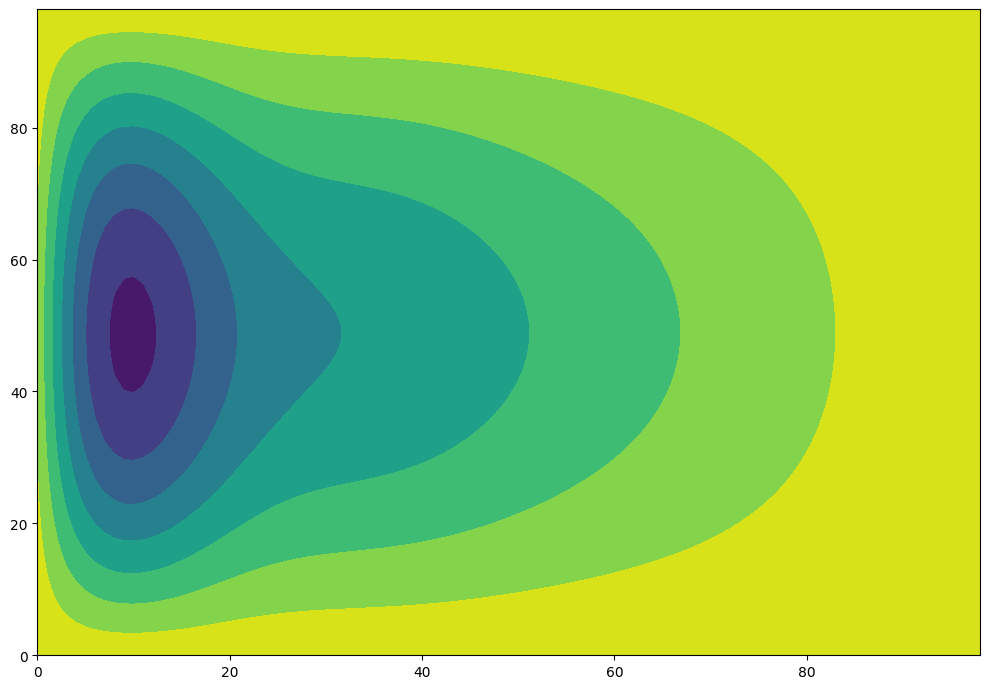

In [13]:
N = 100
dx = 1/N
x = np.linspace(dx,1-dx,N-1)
y = np.linspace(dx,1-dx,N-1)
x, y = np.meshgrid(x,y)
pi = np.pi
dt = 0.005

  
lap = laplacian2D(N-1)/dx**2
ddx = ddx2D(N-1)/(2*dx)
ddy = ddy2D(N-1)/(2*dx)
#lap = lap.toarray()

r = 0.1
beta = 1
nu = 0.0001

A = r * lap + beta * ddx
B = - nu * lap.dot(lap) + beta * ddx
C = 1/dt * lap - nu * lap.dot(lap) + beta * ddx
f = 0.05*np.sin(pi*y)
f_long = np.reshape(f,(N-1)**2)

niter=1000
fig, ax = plt.subplots(figsize = (10, 7))

psi_long = spsolve(B,f_long)
psi = np.reshape(psi_long,(N-1,N-1)) 

psis = []

for i in tqdm(range(niter)):
    q_long = lap.dot(psi_long)
    q_long_x = ddx.dot(q_long)
    q_long_y = ddy.dot(q_long)
    psi_long_x = ddx.dot(psi_long)
    psi_long_y = ddy.dot(psi_long)
    rhs_long = f_long - (psi_long_x*q_long_y - psi_long_y*q_long_x) + 1/dt * lap.dot(psi_long)
    
    
    #psi_long = spsolve(A,rhs_long)
    psi_long = spsolve(C,rhs_long)


    psis.append(np.reshape(psi_long,(N-1,N-1)))
    #ax[i].contourf(x,y,psi)

def animate(i):
    ax.clear()
    ax.contourf(psis[i])

ani = animation.FuncAnimation(fig, animate, 1000, interval=0.1, blit=False)

In [14]:
from IPython.display import HTML
HTML(ani.to_jshtml())

/usr/local/python/3.10.4/lib/python3.10/site-packages/matplotlib/contour.py:1479: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/usr/local/python/3.10.4/lib/python3.10/site-packages/matplotlib/contour.py:1480: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


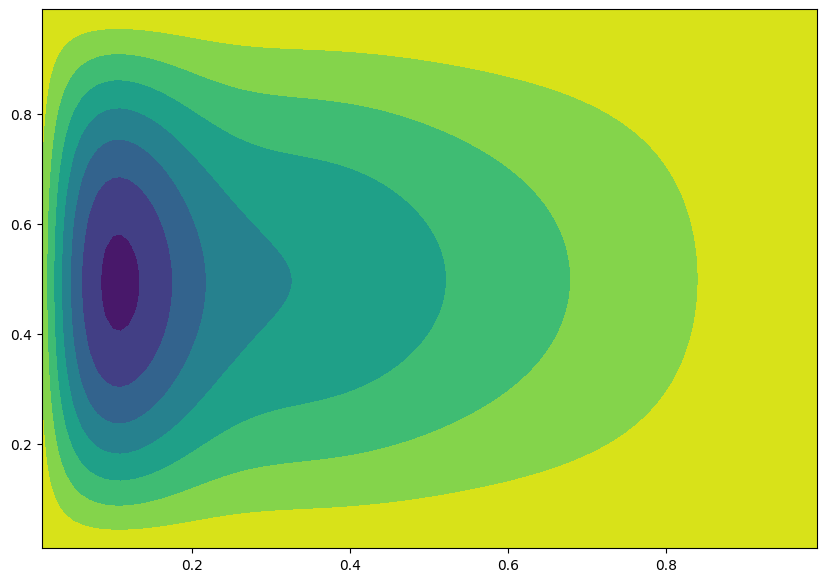

KeyboardInterrupt: 

In [37]:
from matplotlib import animation
matplotlib.use('Qt5Agg')
N = 100
dx = 1/N
x = np.linspace(dx,1-dx,N-1)
y = np.linspace(dx,1-dx,N-1)
x, y = np.meshgrid(x,y)
pi = np.pi
dt = 0.01

  
lap = laplacian2D(N-1)/dx**2
ddx = ddx2D(N-1)/(2*dx)
ddy = ddy2D(N-1)/(2*dx)
#lap = lap.toarray()

r = 0.1
beta = 1
nu = 0.0001

A = r * lap + beta * ddx
B = - nu * lap.dot(lap) + beta * ddx
C = 1/dt * lap - nu * lap.dot(lap) + beta * ddx
f = 0.05*np.sin(pi*y)
f_long = np.reshape(f,(N-1)**2)

niter=80
fig, ax = plt.subplots(figsize = (10, 7))

psi_long = spsolve(B,f_long)

for i in range(niter):
    q_long = lap.dot(psi_long)
    q_long_x = ddx.dot(q_long)
    q_long_y = ddy.dot(q_long)
    psi_long_x = ddx.dot(psi_long)
    psi_long_y = ddy.dot(psi_long)
    rhs_long = f_long - (psi_long_x*q_long_y - psi_long_y*q_long_x) + 1/dt * lap.dot(psi_long)
    
    
    #psi_long = spsolve(A,rhs_long)
    psi_long = spsolve(C,rhs_long)


    psi = np.reshape(psi_long,(N-1,N-1)) 
    ax.contourf(x,y,psi)

    plt.pause(0.001)
    fig.canvas.draw_idle()
    fig.canvas.start_event_loop(1)

    plt.show()

In [ ]:
def psi_nonlin(x, y, epsilon):
    term1 = np.sin(np.pi * y) * (1 - x - np.exp(-x/epsilon))
    term2 = -(np.pi ** 3)/(2 * epsilon**3) * np.sin(2 * np.pi * y) * x * np.exp(-x/epsilon)

    return term1 + term2




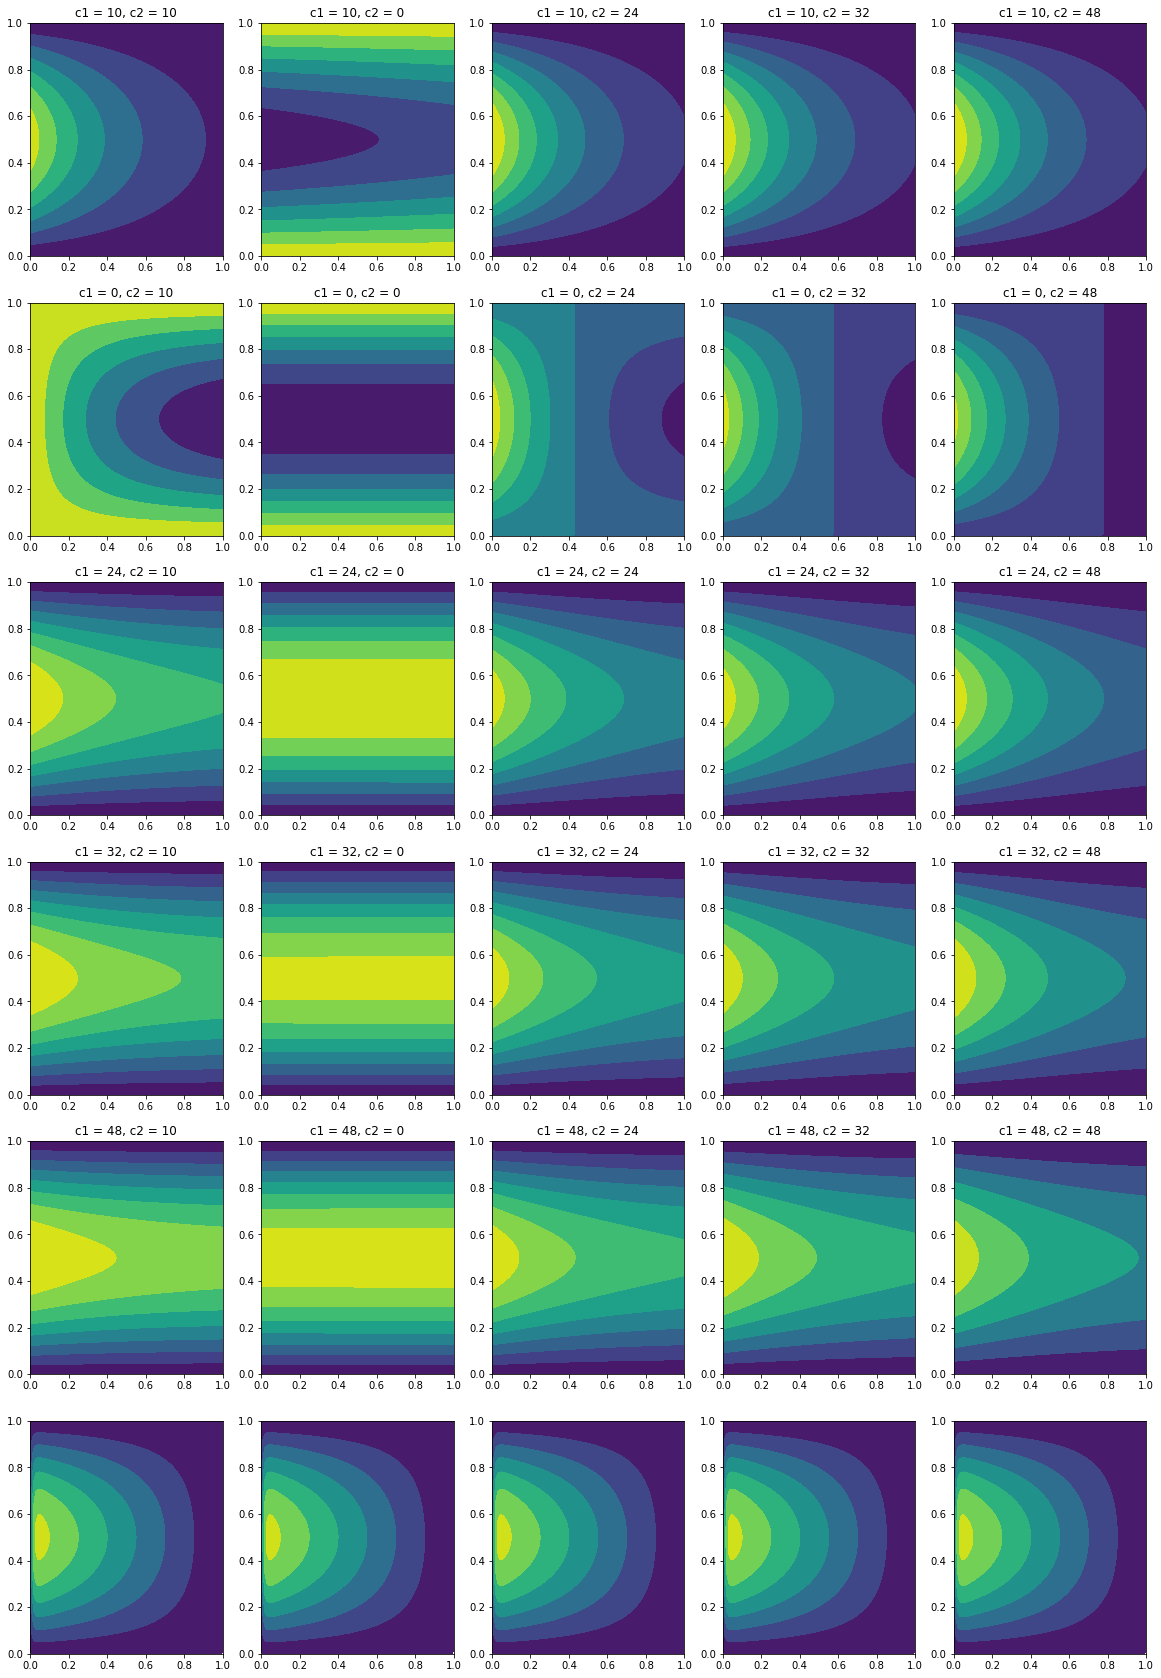

In [3]:
#fresh attempt at c variation using multiple plots rather than animation

epsilon = 0.01 
A = 1

C = [10, 0, 24, 32, 48]

def psi_approx(x, y):
    return (1 - x - np.exp(-x/epsilon)) * A * np.sin(np.pi * y)

def psi_exact(x, y, C_1, C_2):
    return np.sin(np.pi * y) * (C_1 * np.exp((-1 + np.sqrt(1 + 4 * epsilon**2 * np.pi**2))*x) + C_2 * np.exp((-1 - np.sqrt(1 + 4 * epsilon**2 * np.pi**2))*x) - A/(np.pi**2*epsilon))
    
N = 100
x = np.linspace(0,1,N)
y = np.linspace(0,1,N)
x, y = np.meshgrid(x,y)

fig, ax = plt.subplots(6,5, figsize = (20,30))

for i in range(6):
    for j in range(5):
        if i == 5:
            ax[i,j].contourf(x,y,psi_approx(x,y))
        else:
            ax[i,j].contourf(x,y,psi_exact(x, y, C[i], C[j]))
            ax[i,j].set_title(f'c1 = {C[i]}, c2 = {C[j]}')



plt.show()

In [4]:
'''
Trying to Fourierise, this comes out with different C1 and C2 coefficients to what is in the overleaf so is wrong, but I 
cannot figure out where
''' 

import numpy as np
import sympy as sym
sym.init_printing()
from IPython.display import display_latex


x,n,y, epsilon = sym.symbols('x, n, y, epsilon')

f = sym.Function('f')
psi = sym.Function('psi')

#def func(x):
    #return 2*x
    
func = -sym.pi*sym.sin(sym.pi*y)
#func = 2*y

epsilon = 0.5
n = 1


def exact_sol(func):
    
    epos = sym.E**((-1 + sym.sqrt(1+4*n**2*sym.pi**2*epsilon**2))/(2*epsilon))
    eneg = sym.E**((-1 - sym.sqrt(1+4*n**2*sym.pi**2*epsilon**2))/(2*epsilon))
    
    eposx = sym.E**(((-1 + sym.sqrt(1+4*n**2*sym.pi**2*epsilon**2))/(2*epsilon)*x))
    enegx = sym.E**(((-1 - sym.sqrt(1+4*n**2*sym.pi**2*epsilon**2))/(2*epsilon)*x))
    
    #find our An value 
    integral = func*sym.sin(n*sym.pi*y)
    A_n = sym.integrate(integral,(y, -1, 1))
    
    #compute matri
    M = sym.Matrix([[1, 1], [epos, eneg]])
    
    A_vec = sym.Matrix([A_n/(n**2*sym.pi**2*epsilon), A_n/(n**2*sym.pi**2*epsilon)])
    #A_vec_2 = sym.Matrix([-1/(sym.pi*epsilon), -1/(sym.pi*epsilon)])
    
    #solve for c values
    C_vec = M.inv()*A_vec
    
    #round C for prettiness 
    for a in C_vec:
        C_vec = C_vec.subs(a, round(a, 2))
    
    solution = sym.Eq(C_vec[0]*eposx + C_vec[1]*enegx + (A_n/(epsilon*sym.pi**2*n**2)), psi(x))
    
    
    return solution


display_latex(exact_sol(func))